# Prediction of AAPL stock using LR with ARMA errors (2010-2021)

## Content
0. [Download Data from Yahoo Finance](#section0)
1. [Data preparation](#section1)
2. [Exploratory Data Analysis](#section2)
3. [Data Testing](#section3)
4. [Fitting an ARMA model](#section4)
5. [Residual Analysis](#section5)
6. [Prediction vs. Realized Values](#section6)

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

### <a id='section0'></a> 0 $\bullet$ Import Apple Stock data from 2010-01-04 to 2021-04-30

In [2]:
start = '2010-01-04'
end = '2021-04-30'

In [3]:
aapl_df = yf.download(tickers='AAPL', start='2010-01-04', end='2021-04-30', interval='1wk')
print(aapl_df.head())
print(aapl_df.tail())
print(aapl_df.shape[0])

[*********************100%***********************]  1 of 1 completed
                Open      High       Low     Close  Adj Close        Volume
Date                                                                       
2010-01-01  7.622500  7.699643  7.466071  7.520714   6.467082  2.124926e+09
2010-01-08  7.510714  7.607143  7.289286  7.479643   6.431766  2.543086e+09
2010-01-15  7.533214  7.698214  7.352500  7.431071   6.389999  2.544382e+09
2010-01-22  7.385000  7.632500  7.041429  7.117500   6.120359  6.710648e+09
2010-01-29  7.181429  7.221429  6.794643  6.858929   5.898012  4.067151e+09
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2021-03-26  120.349998  124.180000  118.860001  123.000000  122.791428   
2021-04-02  123.870003  130.389999  123.070000  130.360001  130.138947   
2021-04-09  129.800003  135.000000  129.470001  134.500000  134.271927   
2021-04-16  134.300003  135.5

### <a id='section1'></a> 1 $\bullet$ Data preparation

#### Check missing values

In [4]:
miss = aapl_df.isnull().sum()
print('no missing values' if miss.sum() == 0 else 'there are %d missing values' % miss.sum())
aapl_df[aapl_df.isna().any(axis=1)].head()

there are 222 missing values


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-08-09,NaN,NaN,NaN,NaN,NaN,NaN
2012-11-07,NaN,NaN,NaN,NaN,NaN,NaN
2013-02-07,NaN,NaN,NaN,NaN,NaN,NaN
2013-05-09,NaN,NaN,NaN,NaN,NaN,NaN
2013-08-08,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
aapl_df = aapl_df.dropna()  # remove the missing value rows

#### Date in the dataframe is set as index
Check the possible frequency of the index (date)

In [6]:
pd.infer_freq(aapl_df.index)

'W-FRI'

#### Maximum drawdown

<AxesSubplot:xlabel='date'>

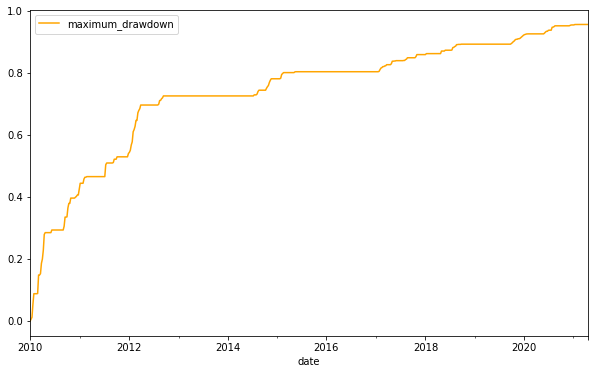

In [7]:
df0 = pd.DataFrame(index=['date'], columns=['maximum_drawdown'])
for i in aapl_df.index:
    maxdd_i = (aapl_df[:i]['Adj Close'].max() - aapl_df[:i]['Adj Close'].min()) / aapl_df[:i]['Adj Close'].max()
    df0 = pd.concat([df0, pd.DataFrame({'date': [i], 'maximum_drawdown': [maxdd_i]})], axis=0)
df0.set_index('date', inplace=True)
df0.dropna(inplace=True)

df0.plot(figsize=(10,6), c='orange')

#### Calculate arithmetic return

In [8]:
week_rt = (aapl_df['Adj Close']/aapl_df['Adj Close'].shift(1) - 1).rename('Weekly Return')
aapl_df = pd.concat([aapl_df, week_rt], axis=1)
year_rt = aapl_df['Adj Close']/aapl_df['Adj Close'].shift(52) - 1

#### Plot the prices and return

<AxesSubplot:xlabel='Date'>

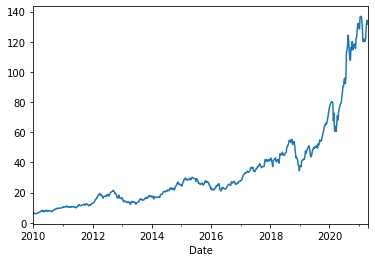

In [9]:
aapl_df['Adj Close'].plot()  # Weekly price of AAPL for the past 10 years

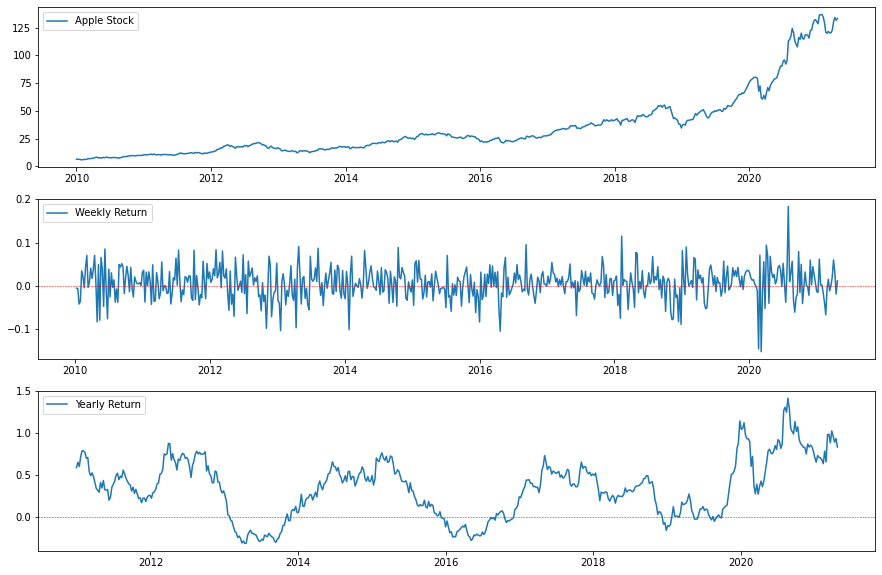

In [10]:
fig, ax = plt.subplots(3, figsize=(15, 10))
ax[0].plot(aapl_df['Adj Close'])
ax[1].plot(week_rt)
ax[2].plot(year_rt)
ax[1].axhline(y=0, c="r", linewidth=0.5, linestyle='--')
ax[2].axhline(y=0, c="r", linewidth=0.5, linestyle='--')
ax[0].legend(['Apple Stock'])
ax[1].legend(['Weekly Return'])
ax[2].legend(['Yearly Return'])

### <a id='section2'></a> 2 $\bullet$ Exploratory Data Analysis

#### Trend of other tech stocks (before smoothing)

In [11]:
tech_df = yf.download(tickers='AAPL IBM MSFT F', start=start, end=end, interval='1d')  # daily frequency

[*********************100%***********************]  4 of 4 completed


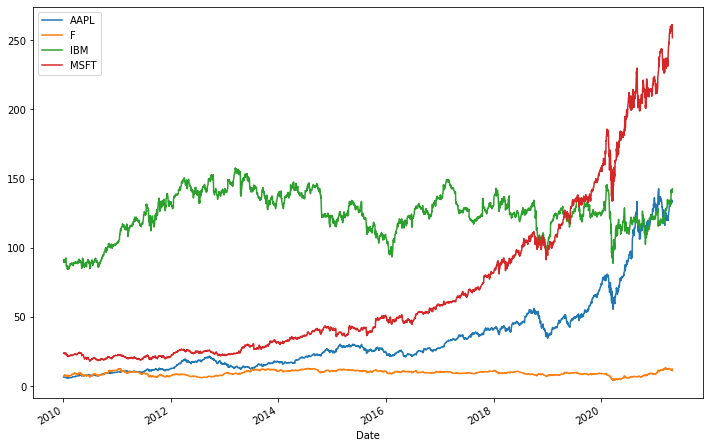

In [12]:
tech_df['Adj Close'].plot(figsize=(12,8))
del tech_df

#### Histograms

Text(0.5, 1.0, 'AAPL weekly return')

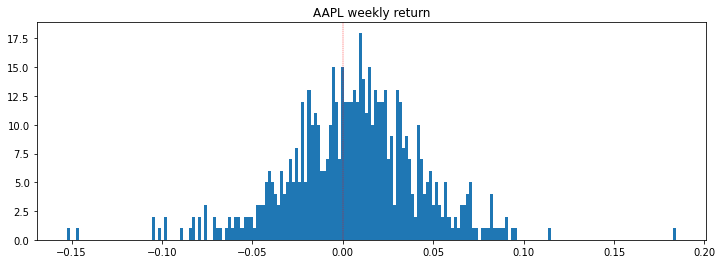

In [13]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.hist(week_rt, bins=200)
ax.axvline(x=0, c="r", linewidth=0.4, linestyle='--')
plt.title('AAPL weekly return')

#### Histogram with Kernel Density Estimate (KDE)

Text(0.5, 1.0, 'AAPL weekly return')

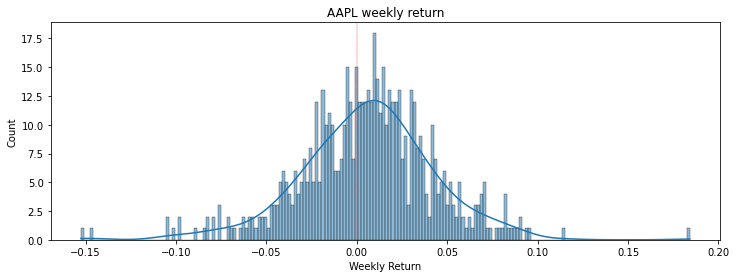

In [14]:
fig, ax = plt.subplots(figsize=(12, 4))
sns.histplot(x=week_rt, kde=True, bins=200, ax=ax)
ax.axvline(x=0, c="r", linewidth=0.4, linestyle='--')
plt.title('AAPL weekly return')

#### Empirical cumulative density function

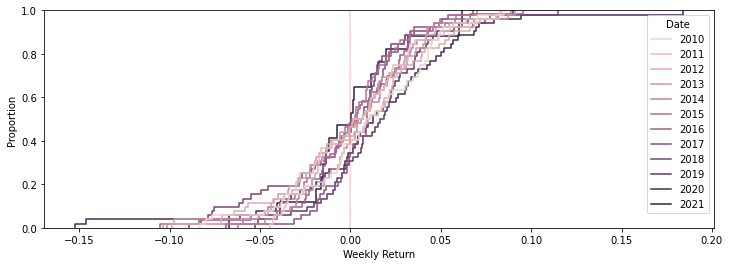

In [15]:
fig, ax = plt.subplots(figsize=(12,4))
sns.ecdfplot(data=aapl_df, x=week_rt, hue=aapl_df.index.year, ax=ax)
ax.axvline(x=0, c="r", linewidth=0.4, linestyle='--')

#### Stacked histogram

Plot the histogram of the AAPL weekly returns, adding a hue for the different years and stacking the different years.

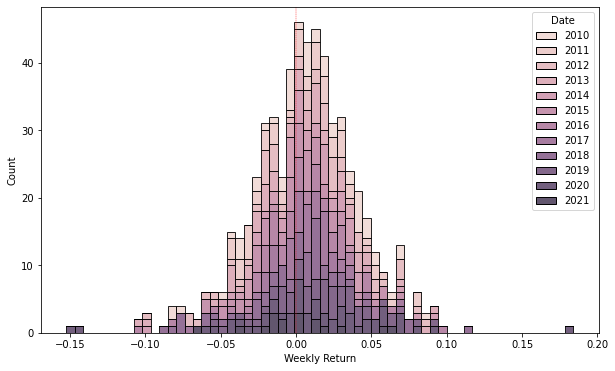

In [16]:
fig, ax = plt.subplots(figsize=(10,6))
sns.histplot(data=aapl_df, x=week_rt, hue=aapl_df.index.year, multiple='stack', bins=60, ax=ax)
ax.axvline(x=0, c="r", linewidth=0.4, linestyle='--')

#### Boxplot

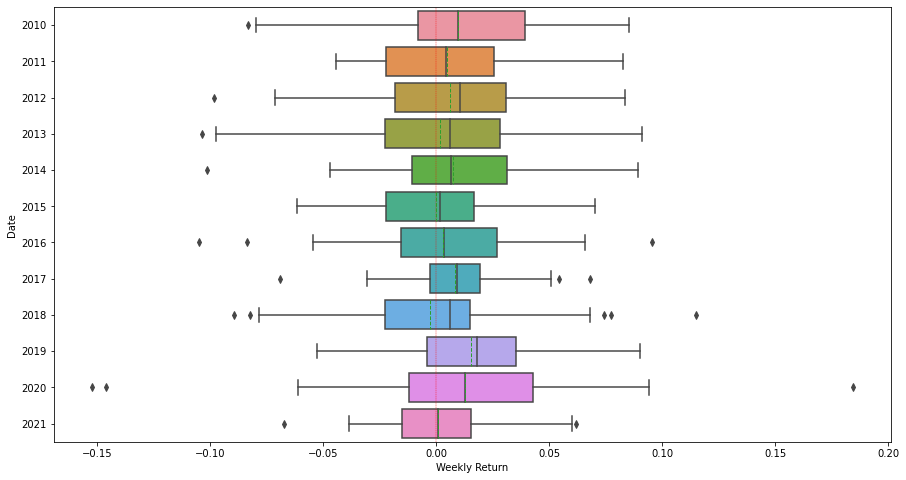

In [17]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.boxplot(x=week_rt, y=aapl_df.index.year, orient='h',
            showmeans=True, meanline=True, ax=ax)
ax.axvline(x=0, c="r", linewidth=0.4, linestyle='--')

#### Scatterplot

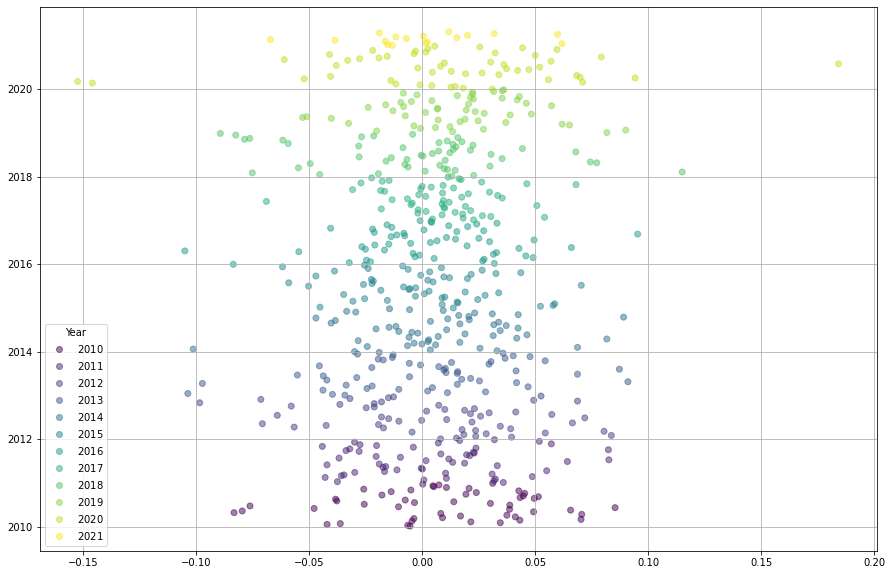

In [18]:
# plt.scatter(x=week_rt, y=aapl_df.index, c=aapl_df.index.year, alpha=0.5)
# plt.legend(aapl_df.index.year)
fig, ax = plt.subplots(figsize=(15, 10))
scatter = ax.scatter(x=week_rt, y=aapl_df.index, c=aapl_df.index.year, alpha=0.5)
ax.legend(*scatter.legend_elements(),
                    loc='lower left', title='Year')
ax.grid()

### <a id='section3'></a> 3 $\bullet$ Data testing

#### Test for stationarity

In [19]:
from statsmodels.tsa.api import adfuller, kpss, acf

Augmented Dickey-Fuller stationarity test (null hypothesis: non-stationarity)

In [20]:
def print_adf_test(x):
    regressions = {'constant only': 'c',
                   'constant and trend': 'ct',
                   'constant, and linear and quadratic trend': 'ctt',
                   'no constant, no trend': 'nc'}
    df = pd.DataFrame(data=np.zeros((len(regressions),2)),
                      index=regressions,
                      columns=['test statistic', 'p-value'])
    for reg in regressions:
        res = adfuller(x, regression=regressions[reg])
        df.loc[reg, 'test statistic'] = res[0]
        df.loc[reg, 'p-value'] = res[1]
    display(df.round(4))
    return df

In [21]:
adf_test_price = print_adf_test(aapl_df['Adj Close'])  # ADF test for weekly price

,test statistic,p-value
constant only,2.2244,0.9989
constant and trend,0.5666,0.9970
"constant, and linear and quadratic trend",-1.3009,0.9687
"no constant, no trend",3.0212,0.9998


p-value > 0.05, **we cannot reject the null hypothesis of non-stationarity**.

In [22]:
adf_test_price_ex2020 = print_adf_test(aapl_df[:'2019']['Adj Close'])

,test statistic,p-value
constant only,2.0183,0.9987
constant and trend,0.2155,0.9959
"constant, and linear and quadratic trend",-1.5569,0.9364
"no constant, no trend",3.3834,1.0000


Even if we remove the data after 2020, we still cannot reject the null hypothesis of non-stationarity.

In [23]:
adf_test_rt = print_adf_test(week_rt.dropna())  # ADF test for weekly return

,test statistic,p-value
constant only,-12.6643,0.0
constant and trend,-12.6570,0.0
"constant, and linear and quadratic trend",-12.7677,0.0
"no constant, no trend",-12.0829,0.0


p-value < 0.001, reject the null hypothesis of non-stationarity. **The weekly return of AAPL is stationary.**

Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test (Null hypothesis: stationarity)

In [24]:
def print_kpss_test(x, regression='c'):
    regressions = {'constant only': 'c',
                   'constant and trend': 'ct'}
    df = pd.DataFrame(data=np.zeros((len(regressions),2)),
                      index=regressions,
                      columns=['test statistic', 'p-value'])
    for reg in regressions:
        res = kpss(x, regression=regressions[reg], nlags='auto')
        df.loc[reg, 'test statistic'] = res[0]
        df.loc[reg, 'p-value'] = res[1]
    display(df.round(4))
    return df

In [25]:
print_kpss_test(aapl_df['Adj Close'])  # KPSS test for weekly price

C:\Users\10271\AppData\Local\Programs\Python\Python39\Lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(
C:\Users\10271\AppData\Local\Programs\Python\Python39\Lib\site-packages\statsmodels\tsa\stattools.py:1906: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


,test statistic,p-value
constant only,2.5662,0.01
constant and trend,0.5452,0.01


,test statistic,p-value
constant only,2.566220,0.01
constant and trend,0.545157,0.01


p-value < 0.01, **we have 99% confidence to reject the null hypothesis of stationarity**.

In [26]:
print_kpss_test(week_rt.dropna())  # KPSS test for weekly return

C:\Users\10271\AppData\Local\Programs\Python\Python39\Lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Users\10271\AppData\Local\Programs\Python\Python39\Lib\site-packages\statsmodels\tsa\stattools.py:1910: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


,test statistic,p-value
constant only,0.1052,0.1
constant and trend,0.0818,0.1


,test statistic,p-value
constant only,0.105217,0.1
constant and trend,0.081814,0.1


p-value > 0.1, we cannot reject the null hypothesis of stationarity. **The weekly return is stationary.**

#### Test for autocorrelation

Autocorrelation function ACF:
    $$\rho(h) = \frac{\gamma(h)}{\gamma(0)}$$
    where $$\gamma(h) = Cov(X_t, X_{t-h})$$

$\bullet$ Individual test for some h > 0, 
$$H_0: \rho(h) = 0$$
$$H_1: \rho(h) ≠ 0$$

In practice, one need at least T ⩾ 50 (T is the number of observations) and h ⩽ T/4. In this case T = 1153, so h ⩽ 288.

In [27]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [28]:
def acf_pacf(x, lags=50):
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    plot_acf(x, lags=lags, ax=ax[0])
    plot_pacf(x, lags=lags, ax=ax[1])
    
    # add the 95% confidence interval using variance = 1/N
    stderr = stats.norm.ppf(.975) / np.sqrt(len(x))
    ax[0].hlines([stderr, -stderr], 0, lags, colors='r', linestyles='dotted', label='95% confidence interval')
    ax[1].hlines([stderr, -stderr], 0, lags, colors='r', linestyles='dotted', label='95% confidence interval')
    
    ax[0].legend()
    ax[1].legend()
    
    return fig

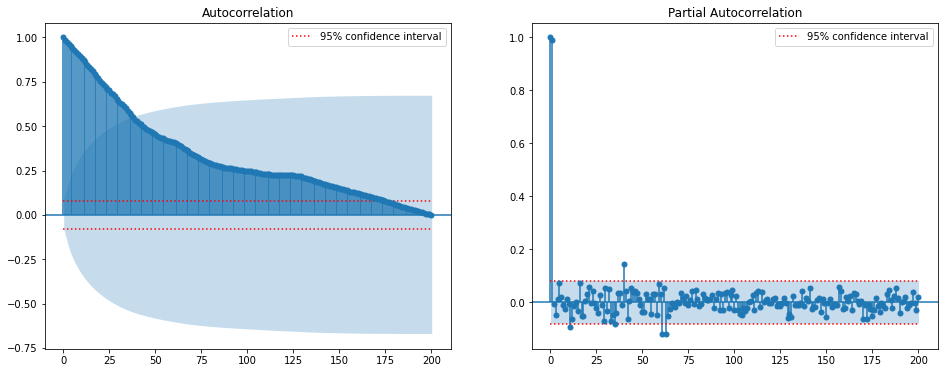

In [29]:
acf_plot_price = acf_pacf(aapl_df['Adj Close'], lags=200)

As lag increases, the autocorrelation effect decreases; but clearly when the lags are small, the autocorrelation is strong. Because all the  For partial autocorrelation, the situation is much better, but when lag = 1 and when lag = 2, there are still a high autocorrelation effect. **We can conclude that the stock price of AAPL is not white noise.**

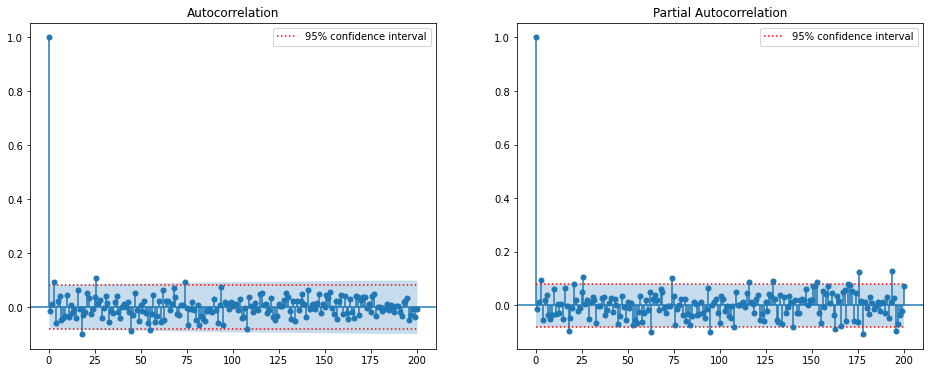

In [30]:
acf_plot_rt = acf_pacf(week_rt.dropna(), lags=200)

We can conclude that **weekly return is not a white noise.**

$\bullet$ Joint test: the Ljung–Box Q test
For some m << T,
$$\begin{align}
H_0: \rho(1) = ... = \rho(m) = 0\\
H_1: \exists 1 ≤ h ≤ m,\rho(h) ≠ 0 \\
\end{align}$$

In [31]:
def print_acf(x, lags):
    val, qstat, pval = acf(x, fft=False, qstat=True, nlags=lags.max())
    df = pd.DataFrame(np.array([qstat[lags-1], 100 * pval[lags-1]]).T,
                      columns=['Q Statistic', 'p-value (%)'],
                      index=[f'up to lag {lag}' for lag in lags]).round(2)
    display(df)
    return df

In [32]:
lags = np.array([1, 2, 3, 5, 7, 10, 20])
res1 = print_acf(aapl_df['Adj Close'], lags)

,Q Statistic,p-value (%)
up to lag 1,579.73,0.0
up to lag 2,1146.35,0.0
up to lag 3,1699.02,0.0
up to lag 5,2766.19,0.0
up to lag 7,3789.92,0.0
up to lag 10,5245.20,0.0
up to lag 20,9296.06,0.0


We can reject the null hypothesis that autocorrelation does not exist. So **weekly price is not a white noise.**

In [33]:
res2 = print_acf(week_rt.dropna(), np.array([1, 3, 5, 10, 20, 25, 30]))

,Q Statistic,p-value (%)
up to lag 1,0.10,74.67
up to lag 3,5.48,14.01
up to lag 5,7.81,16.67
up to lag 10,13.06,22.02
up to lag 20,24.27,23.09
up to lag 25,27.91,31.20
up to lag 30,36.89,18.05


p-value > 0.05, we cannot reject the null hypothesis that autocorrelation does not exist. So weekly return could potentially be whiete noise. **We should use weekly price for the linear model.**

### <a id='section4'></a> 4 $\bullet$ Fitting an ARMA model

$\bullet$ Selecting a model with information criteria 
https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.arma_order_select_ic.html  
`trend='c'` includes constant  
`trend='nc'` no constant: long run mean is zero

In [34]:
from statsmodels.tsa import stattools

# Silence the warning
import warnings
warnings.simplefilter('ignore', FutureWarning)

In [35]:
def select_arma(x, max_ar=2, max_ma=2, trend='c'):
    res = stattools.arma_order_select_ic(x, max_ar=max_ar, max_ma=max_ma, ic=['aic', 'bic'], trend=trend)
    res['aic'].index.names = ['AR Lags']
    res['aic'].columns.names = ['MA Lags']
    res['bic'].index.names = ['AR Lags']
    res['bic'].columns.names = ['MA Lags']
    res['aic'].columns = pd.MultiIndex.from_product([['AIC'],res['aic'].columns])
    res['bic'].columns = pd.MultiIndex.from_product([['BIC'],res['bic'].columns])

    display(res['aic'].round(1))
    print('AIC selected order: ', res['aic_min_order'])
    display(res['bic'].round(1))
    print('BIC selected order: ', res['bic_min_order'])
    
    return res

In [36]:
res = select_arma(aapl_df['Adj Close'], max_ar=4, max_ma=4, trend='c')

C:\Users\10271\AppData\Local\Programs\Python\Python39\Lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\10271\AppData\Local\Programs\Python\Python39\Lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
C:\Users\10271\AppData\Local\Programs\Python\Python39\Lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\10271\AppData\Local\Programs\Python\Python39\Lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_pa

AIC                                
MA Lags       0       1       2       3       4
AR Lags                                        
0        5682.2  4927.1  4331.4  3964.5  3595.2
1        2410.2  2398.4  2396.0  2389.7  2389.7
2        2408.7  2402.8  2401.2  2390.4  2391.3
3        2405.1  2400.7  2393.3  2391.5  2386.2
4        2401.8  2398.3  2393.2  2393.0  2397.1

AIC selected order:  (3, 4)


BIC                                
MA Lags       0       1       2       3       4
AR Lags                                        
0        5691.0  4940.2  4348.9  3986.4  3621.5
1        2423.3  2415.9  2417.9  2416.0  2420.3
2        2426.2  2424.8  2427.5  2421.0  2426.4
3        2427.0  2427.0  2424.0  2426.6  2425.6
4        2428.1  2429.0  2428.3  2432.5  2440.9

BIC selected order:  (1, 1)


Based on the result of BIC, we fit AR(1) model to the dataset

In [37]:
import statsmodels.tsa.arima.model as smt_arima
model = smt_arima.ARIMA(aapl_df['Adj Close'], order=(1, 0, 0))  # ARMA function is deprecated

C:\Users\10271\AppData\Local\Programs\Python\Python39\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  warnings.warn('No frequency information was'
C:\Users\10271\AppData\Local\Programs\Python\Python39\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  warnings.warn('No frequency information was'
C:\Users\10271\AppData\Local\Programs\Python\Python39\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  warnings.warn('No frequency information was'


In [38]:
fitted_model = model.fit()
fitted_model.summary()

C:\Users\10271\AppData\Local\Programs\Python\Python39\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Adj Close   No. Observations:                  591
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -1196.515
Date:                Sun, 06 Jun 2021   AIC                           2399.030
Time:                        15:07:53   BIC                           2412.175
Sample:                    01-01-2010   HQIC                          2404.151
                         - 04-23-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         65.6017     57.569      1.140      0.254     -47.231     178.434
ar.L1          0.9995      0.002    482.935      0.000       0.995       1.004
sigma2         3.3182      0.057     57.744      0.000       3.206       3.431
===================================================================================
Ljung-Box (L1) (Q):                   2.20   Jarque-Bera (JB):             12698.13
Prob(Q):                              0.14   Prob(JB):                         0.00
Heteroskedasticity (H):              31.94   Skew:                             1.00
Prob(H) (two-sided):                  0.00   Kurtosis:                        25.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### <a id='section5'></a> 5 $\bullet$ Residual Analysis

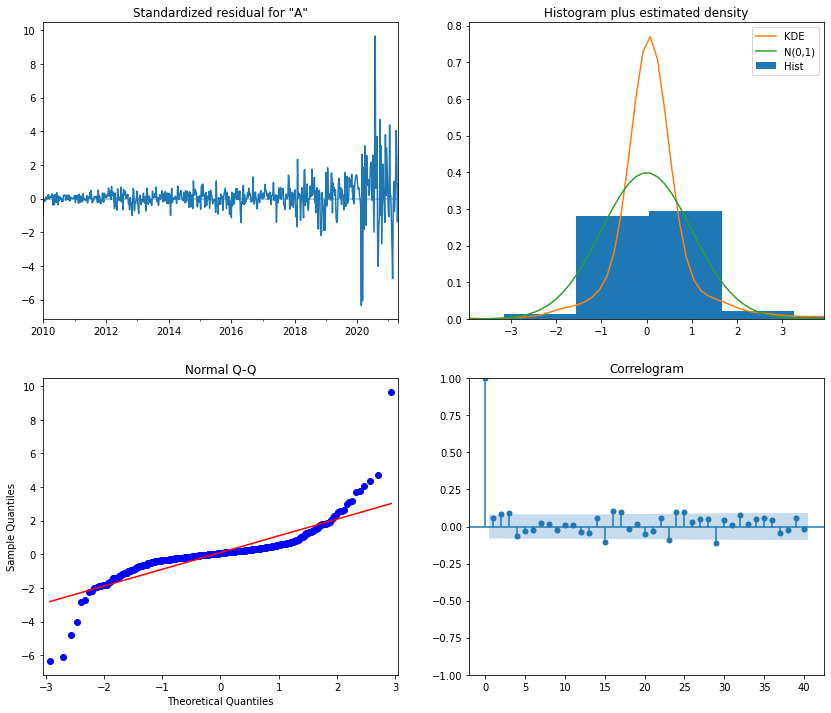

In [39]:
fig = fitted_model.plot_diagnostics(figsize=(14,12), lags=40)

In [40]:
res = print_acf(fitted_model.resid, lags)

,Q Statistic,p-value (%)
up to lag 1,0.35,55.25
up to lag 2,0.96,61.86
up to lag 3,1.83,60.90
up to lag 5,2.10,83.45
up to lag 7,2.21,94.71
up to lag 10,2.34,99.30
up to lag 20,6.41,99.82


p-value > 0.05, we cannot reject the null hypothesis of no autocorrelation.

### <a id='section6'></a> 6 $\bullet$ Prediction vs. Realized Values

In [41]:
forecast = fitted_model.get_forecast(steps=25)  # Predict values for the next 40 weeks
f = forecast.summary_frame()
f.tail()

Adj Close,mean,mean_se,mean_ci_lower,mean_ci_upper
2021-09-17,132.593658,8.308807,116.308695,148.878620
2021-09-24,132.562390,8.502357,115.898077,149.226703
2021-10-01,132.531137,8.691423,115.496261,149.566013
2021-10-08,132.499899,8.876292,115.102686,149.897111
2021-10-15,132.468675,9.057221,114.716847,150.220502


In [42]:
realized_value = yf.Ticker('AAPL').history(start=min(f.index), end=max(f.index))

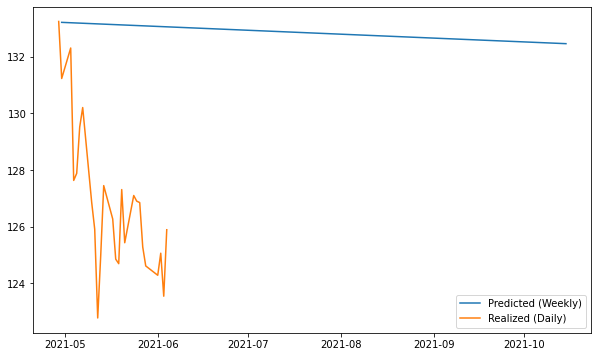

In [43]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(f['mean'], label='Predicted (Weekly)')
ax.plot(realized_value['Close'], label='Realized (Daily)')
ax.legend()

<font color='red'>Apparently the pandemic in 2020 severely influences the price and causes outliers in the price. We try to remove the data after 2020 to have a better prediction. Please check the notebook 02.</font>